In [1]:
"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

"""



print __doc__

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


Faces recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html




C:\ProgramData\Anaconda3\envs\udacity_ml\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\envs\udacity_ml\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes

2017-07-04 16:30:37,798 Loading LFW people faces from C:\Users\Piotrek\scikit_learn_data\lfw_home


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [3]:
###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

`X` seem to be some information about pixels (`len(X_train[0]) == w*h == 1850`)

`y` are labels (who is on picture)

[fetch_lfw_people](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)
> Each picture is centered on a single face. Each pixel of each channel (color in RGB) is encoded by a float in range 0.0 - 1.0.

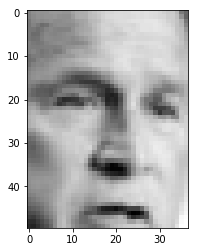

In [4]:
# Training data are just images in greyscale

test_img = X_train[0].reshape((h, w))
pl.imshow(test_img, cmap=pl.cm.gray)
pl.show()

In [5]:
###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = PCA(svd_solver='randomized', n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

# print "Variance: ", pca.explained_variance_ratio_

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)

Extracting the top 150 eigenfaces from 966 faces
done in 0.523s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.046s


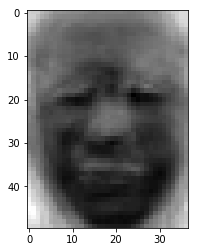

number of eigenfaces:  150
X_train_pca[0]:  150
[-1.95590394 -1.01103667  2.01655377  0.05818006 -1.19493895 -0.65541181
 -0.7578873  -0.58811435 -1.2509728  -0.16673512  0.34548107  0.1492277
  0.61283827  0.45854695  2.95888376  1.25394945 -3.12016709 -0.54171643
  3.88496948 -1.66201815  0.15681932  0.14594843 -0.89649633 -0.43600642
  1.9368615   0.70674769  0.75102875 -0.18808425 -0.14761489  2.62351448
 -0.17832326  0.14424209  2.20507427 -1.20206895  1.43208715 -0.65781068
 -0.12560832  0.83519661 -1.22255203  1.81703588 -1.20862339  1.96385861
  1.47926805  1.1524438  -1.96991641 -0.01356837  0.96938654 -0.36724961
  2.68850735  4.37856905  3.2215313   0.19292805  0.09117036 -0.10416624
  2.71946979 -1.04457724  0.89414444 -0.51555626  0.67312537  0.00828229
  0.58694846  0.50965635 -1.0173809  -0.32494604  2.34369924 -4.12414648
  2.01214267  0.48289127  4.06179418 -0.99940512  0.00718144 -1.44569942
 -0.34444204 -0.84296355  0.44397728 -0.18719574  0.829878   -1.26599141
  2.

In [11]:
# How eigenfaces look like

test_img = eigenfaces[0].reshape((h, w))
pl.imshow(test_img, cmap=pl.cm.gray)
pl.show()

print "number of eigenfaces: ", len(eigenfaces)

print "X_train_pca[0]: ", len(X_train_pca[0])
print X_train_pca[0]

First eigenface represents the maximal variation that it sees across the data.

Variance: "spread" of a data distribution (similar to standard deviation). Feature that has a large variance has instances that fall over a large numerical range of values that it can take [.](https://classroom.udacity.com/courses/ud120/lessons/2962298545/concepts/29403485440923)

Principal component via wiki:
> This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors are an uncorrelated orthogonal basis set. [.](https://en.wikipedia.org/wiki/Principal_component_analysis)

Here we can see, that each of real pictures probably has as many values as number of eigenfaces we created. Those are later used in SVC classification:

In [7]:
print "Size of X_train_pca: ", len(X_train_pca)
print "Number of real faces photos: ", X_train.shape[0]

Size of X_train_pca:  966
Number of real faces photos:  966


In [8]:
###############################################################################
# Train a SVM classification model

print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_

Fitting the classifier to the training set
done in 21.775s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [9]:
###############################################################################
# Quantitative evaluation of the model quality on the test set

print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))

Predicting the people names on the testing set
done in 0.075s
                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.69      0.69        13
     Colin Powell       0.84      0.88      0.86        60
  Donald Rumsfeld       0.63      0.70      0.67        27
    George W Bush       0.88      0.88      0.88       146
Gerhard Schroeder       0.77      0.80      0.78        25
      Hugo Chavez       0.80      0.53      0.64        15
       Tony Blair       0.85      0.81      0.83        36

      avg / total       0.83      0.83      0.83       322

[[  9   0   2   2   0   0   0]
 [  1  53   1   4   0   1   0]
 [  2   1  19   4   0   0   1]
 [  1   6   5 129   3   1   1]
 [  0   1   0   3  20   0   1]
 [  0   2   0   2   1   8   2]
 [  0   0   3   2   2   0  29]]


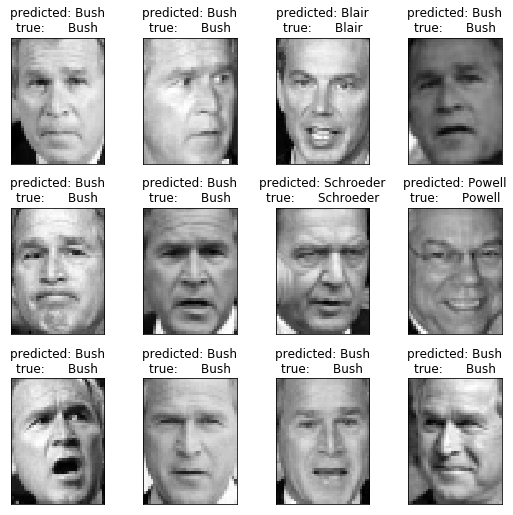

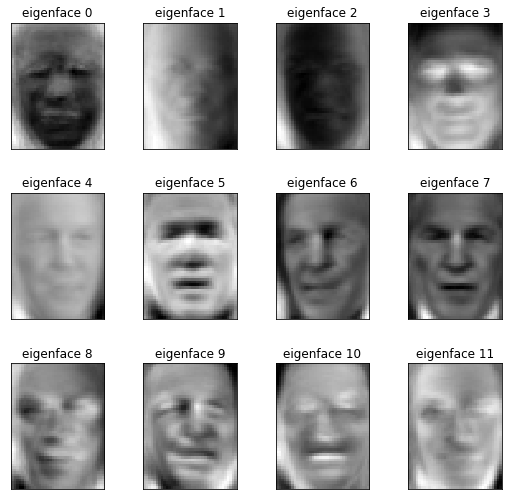

In [10]:
###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())
        
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()